In [1]:
!pip install -q torch datasets transformers peft accelerate evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.6 MB/s eta 0:00:00


In [3]:
import torch
import numpy as np
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
from peft import LoraConfig, get_peft_model, TaskType
from sklearn.metrics import accuracy_score, f1_score, classification_report
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')

# setting the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 1. DATA PREPARATION

class DatasetPreparation:

    def __init__(self, model_name="distilbert-base-uncased"):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.dataset = None

    def load_and_split_data(self):
        """Load sentiment analysis dataset"""
        print("LOADING DATASET: Twitter Financial News Sentiment")

        # loading the dataset: twitter financial news sentiment
        dataset = load_dataset("zeroshot/twitter-financial-news-sentiment")

        # splitting into train/val/test
        train_test = dataset['train'].train_test_split(test_size=0.3, seed=42)
        test_val = train_test['test'].train_test_split(test_size=0.5, seed=42)

        self.dataset = {
            'train': train_test['train'],
            'validation': test_val['train'],
            'test': test_val['test']
        }

        print(f"\nDataset split:")
        print(f"  Training samples: {len(self.dataset['train'])}")
        print(f"  Validation samples: {len(self.dataset['validation'])}")
        print(f"  Test samples: {len(self.dataset['test'])}")

        # Show examples
        print(f"\nSample examples:")
        for i in range(3):
            example = self.dataset['train'][i]
            label_map = {0: "Bearish", 1: "Bullish", 2: "Neutral"}
            print(f"\n  Example {i+1}:")
            print(f"    Text: {example['text'][:100]}...")
            print(f"    Label: {label_map[example['label']]}")

        return self.dataset

    def tokenize_data(self):
        print("\nTokenizing data...")

        def tokenize_function(examples):
            return self.tokenizer(
                examples['text'],
                padding='max_length',
                truncation=True,
                max_length=128
            )

        tokenized_dataset = {
            'train': self.dataset['train'].map(tokenize_function, batched=True),
            'validation': self.dataset['validation'].map(tokenize_function, batched=True),
            'test': self.dataset['test'].map(tokenize_function, batched=True)
        }

        print("Tokenization complete!")
        return tokenized_dataset

# 2. MODEL SETUP

class ModelSetup:

    def __init__(self, model_name="distilbert-base-uncased", num_labels=3):
        self.model_name = model_name
        self.num_labels = num_labels

    # creating the full finetuning model
    def create_full_finetuning_model(self):
        print("STRATEGY 1: FULL FINE-TUNING")

        model = AutoModelForSequenceClassification.from_pretrained(
            self.model_name,
            num_labels=self.num_labels
        )

        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

        print(f"\nModel: {self.model_name}")
        print(f"Total parameters: {total_params:,}")
        print(f"Trainable parameters: {trainable_params:,}")
        print(f"Trainable %: {100 * trainable_params / total_params:.2f}%")

        return model

    # creating the LoRA model
    def create_lora_model(self, r=8, lora_alpha=16, lora_dropout=0.1):
        print("STRATEGY 2: LoRA (PARAMETER-EFFICIENT FINE-TUNING)")

        # loading the base model
        base_model = AutoModelForSequenceClassification.from_pretrained(
            self.model_name,
            num_labels=self.num_labels
        )

        # configuring LoRA
        lora_config = LoraConfig(
            task_type=TaskType.SEQ_CLS,
            r=r,
            lora_alpha=lora_alpha,
            lora_dropout=lora_dropout,
            target_modules=["q_lin", "v_lin"],
            bias="none"
        )

        # applying LoRA
        model = get_peft_model(base_model, lora_config)

        # print the trainable parameters
        model.print_trainable_parameters()

        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

        print(f"\nLoRA Configuration:")
        print(f"  Rank (r): {r}")
        print(f"  Alpha: {lora_alpha}")
        print(f"  Dropout: {lora_dropout}")
        print(f"  Target modules: {lora_config.target_modules}")
        print(f"\nParameter efficiency:")
        print(f"  Total parameters: {total_params:,}")
        print(f"  Trainable parameters: {trainable_params:,}")
        print(f"  Trainable %: {100 * trainable_params / total_params:.2f}%")

        return model

# 3. TRAINING AND EVALUATION

class ModelTrainer:

    def __init__(self, tokenized_dataset):
        self.tokenized_dataset = tokenized_dataset

    def compute_metrics(self, eval_pred): # using accuracy and F1 score
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)

        accuracy = accuracy_score(labels, predictions)
        f1_macro = f1_score(labels, predictions, average='macro')
        f1_weighted = f1_score(labels, predictions, average='weighted')

        return {
            'accuracy': accuracy,
            'f1_macro': f1_macro,
            'f1_weighted': f1_weighted
        }

    def train_model(self, model, strategy_name, epochs=3, batch_size=16):
        print(f"TRAINING: {strategy_name}")

        # training arguments
        training_args = TrainingArguments(
            output_dir=f"./results/{strategy_name.lower().replace(' ', '_')}",
            eval_strategy="epoch",
            save_strategy="epoch",
            learning_rate=2e-5 if "Full" in strategy_name else 3e-4,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            num_train_epochs=epochs,
            weight_decay=0.01,
            load_best_model_at_end=True,
            metric_for_best_model="f1_macro",
            logging_dir=f'./logs/{strategy_name.lower().replace(" ", "_")}',
            logging_steps=50,
            warmup_steps=100,
            fp16=torch.cuda.is_available(),
            report_to="none"
        )

        # initialising the trainer
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=self.tokenized_dataset['train'],
            eval_dataset=self.tokenized_dataset['validation'],
            compute_metrics=self.compute_metrics,
            callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
        )

        # training time
        start_time = time.time()
        train_result = trainer.train()
        training_time = time.time() - start_time

        print(f"\nTraining completed in {training_time:.2f} seconds")
        print(f"Training loss: {train_result.training_loss:.4f}")

        # evaluate on the validation set
        print("\nEvaluating on validation set...")
        val_results = trainer.evaluate()

        print(f"\nValidation Results:")
        print(f"  Accuracy: {val_results['eval_accuracy']:.4f}")
        print(f"  F1 (Macro): {val_results['eval_f1_macro']:.4f}")
        print(f"  F1 (Weighted): {val_results['eval_f1_weighted']:.4f}")

        # evaluating on the test set
        print("\nEvaluating on test set...")
        test_results = trainer.evaluate(self.tokenized_dataset['test'])

        print(f"\nTest Results:")
        print(f"  Accuracy: {test_results['eval_accuracy']:.4f}")
        print(f"  F1 (Macro): {test_results['eval_f1_macro']:.4f}")
        print(f"  F1 (Weighted): {test_results['eval_f1_weighted']:.4f}")

        # get the predictions for detailed analysis
        predictions = trainer.predict(self.tokenized_dataset['test'])
        pred_labels = np.argmax(predictions.predictions, axis=-1)
        true_labels = predictions.label_ids

        # classification report
        print("\nDetailed Classification Report:")
        target_names = ['Bearish', 'Bullish', 'Neutral']
        print(classification_report(true_labels, pred_labels, target_names=target_names))

        return {
            'trainer': trainer,
            'train_time': training_time,
            'val_results': val_results,
            'test_results': test_results,
            'predictions': pred_labels,
            'true_labels': true_labels
        }


Using device: cuda


In [4]:
# 4. COMPARISON AND VISUALIZATION

class ResultsComparison:

    def __init__(self):
        self.results = {}

    def add_results(self, strategy_name, results):
        self.results[strategy_name] = results

    def compare_strategies(self):
        print("STRATEGY COMPARISON")
        print(f"\n{'Strategy':<25} {'Test Acc':>12} {'Test F1':>12} {'Train Time':>12} {'Params':>15}")

        for strategy_name, results in self.results.items():
            test_acc = results['test_results']['eval_accuracy']
            test_f1 = results['test_results']['eval_f1_macro']
            train_time = results['train_time']

            # geting the parameter count
            model = results['trainer'].model
            trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

            print(f"{strategy_name:<25} {test_acc:>12.4f} {test_f1:>12.4f} "
                  f"{train_time:>11.2f}s {trainable_params:>14,}")

    def plot_comparison(self):
        strategies = list(self.results.keys())

        # extract the metrics
        test_acc = [self.results[s]['test_results']['eval_accuracy'] for s in strategies]
        test_f1 = [self.results[s]['test_results']['eval_f1_macro'] for s in strategies]
        train_time = [self.results[s]['train_time'] for s in strategies]

        # calculate percentage of trainable parameters
        trainable_pct = []
        for strategy in strategies:
            model = self.results[strategy]['trainer'].model
            total = sum(p.numel() for p in model.parameters())
            trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
            trainable_pct.append(100 * trainable / total)

        # creating subplots
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        fig.suptitle('Fine-tuning Strategy Comparison', fontsize=16, fontweight='bold')

        # plot 1: Test Accuracy
        axes[0, 0].bar(strategies, test_acc, color=['#3498db', '#e74c3c'])
        axes[0, 0].set_ylabel('Accuracy', fontsize=11)
        axes[0, 0].set_title('Test Accuracy', fontsize=12, fontweight='bold')
        axes[0, 0].set_ylim([0, 1])
        for i, v in enumerate(test_acc):
            axes[0, 0].text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')

        # plot 2: Test F1 Score
        axes[0, 1].bar(strategies, test_f1, color=['#3498db', '#e74c3c'])
        axes[0, 1].set_ylabel('F1 Score (Macro)', fontsize=11)
        axes[0, 1].set_title('Test F1 Score', fontsize=12, fontweight='bold')
        axes[0, 1].set_ylim([0, 1])
        for i, v in enumerate(test_f1):
            axes[0, 1].text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')

        # plot 3: Training Time
        axes[1, 0].bar(strategies, train_time, color=['#3498db', '#e74c3c'])
        axes[1, 0].set_ylabel('Time (seconds)', fontsize=11)
        axes[1, 0].set_title('Training Time', fontsize=12, fontweight='bold')
        for i, v in enumerate(train_time):
            axes[1, 0].text(i, v + 5, f'{v:.1f}s', ha='center', fontweight='bold')

        # plot 4: Trainable Parameters
        axes[1, 1].bar(strategies, trainable_pct, color=['#3498db', '#e74c3c'])
        axes[1, 1].set_ylabel('Trainable Parameters (%)', fontsize=11)
        axes[1, 1].set_title('Parameter Efficiency', fontsize=12, fontweight='bold')
        axes[1, 1].set_ylim([0, 110])
        for i, v in enumerate(trainable_pct):
            axes[1, 1].text(i, v + 3, f'{v:.2f}%', ha='center', fontweight='bold')

        plt.tight_layout()
        plt.savefig('finetuning_comparison.png', dpi=300, bbox_inches='tight')
        print("\nComparison plot saved as 'finetuning_comparison.png'")
        plt.show()

Ng Rui Bin, Damien IA3
Comparing Full Fine-tuning vs LoRA on Financial Sentiment Analysis
LOADING DATASET: Twitter Financial News Sentiment

Dataset split:
  Training samples: 6680
  Validation samples: 1431
  Test samples: 1432

Sample examples:

  Example 1:
    Text: Corcept prevails in Korlym patent challenge; shares up 4%...
    Label: Bullish

  Example 2:
    Text: Wayfair stumbles after Citron takes another whack...
    Label: Bearish

  Example 3:
    Text: "Things are normalizing": ETF market action is "encouraging" despite economic worries, investor says...
    Label: Bullish

Tokenizing data...


Map:   0%|          | 0/6680 [00:00<?, ? examples/s]

Map:   0%|          | 0/1431 [00:00<?, ? examples/s]

Map:   0%|          | 0/1432 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenization complete!
EXECUTING STRATEGY 1: FULL FINE-TUNING
STRATEGY 1: FULL FINE-TUNING

Model: distilbert-base-uncased
Total parameters: 66,955,779
Trainable parameters: 66,955,779
Trainable %: 100.00%
TRAINING: Full Fine-tuning


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,0.488600,0.425882,0.849057,0.794961,0.844684
2,0.282400,0.427144,0.860238,0.814803,0.857945
3,0.202100,0.432527,0.859539,0.817491,0.859441



Training completed in 111.77 seconds
Training loss: 0.3819

Evaluating on validation set...



Validation Results:
  Accuracy: 0.8595
  F1 (Macro): 0.8175
  F1 (Weighted): 0.8594

Evaluating on test set...

Test Results:
  Accuracy: 0.8527
  F1 (Macro): 0.7955
  F1 (Weighted): 0.8525


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Detailed Classification Report:
              precision    recall  f1-score   support

     Bearish       0.71      0.67      0.69       184
     Bullish       0.78      0.81      0.79       300
     Neutral       0.90      0.90      0.90       948

    accuracy                           0.85      1432
   macro avg       0.80      0.79      0.80      1432
weighted avg       0.85      0.85      0.85      1432

EXECUTING STRATEGY 2: LoRA
STRATEGY 2: LoRA (PARAMETER-EFFICIENT FINE-TUNING)
trainable params: 740,355 || all params: 67,696,134 || trainable%: 1.0936

LoRA Configuration:
  Rank (r): 8
  Alpha: 16
  Dropout: 0.1
  Target modules: {'v_lin', 'q_lin'}

Parameter efficiency:
  Total parameters: 67,696,134
  Trainable parameters: 740,355
  Trainable %: 1.09%
TRAINING: LoRA


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,0.543200,0.457499,0.821104,0.753077,0.812733
2,0.418300,0.435429,0.835080,0.783483,0.832833
3,0.387200,0.419740,0.836478,0.786709,0.835662



Training completed in 57.21 seconds
Training loss: 0.4830

Evaluating on validation set...



Validation Results:
  Accuracy: 0.8365
  F1 (Macro): 0.7867
  F1 (Weighted): 0.8357

Evaluating on test set...

Test Results:
  Accuracy: 0.8415
  F1 (Macro): 0.7802
  F1 (Weighted): 0.8411

Detailed Classification Report:
              precision    recall  f1-score   support

     Bearish       0.67      0.68      0.68       184
     Bullish       0.78      0.75      0.77       300
     Neutral       0.89      0.90      0.90       948

    accuracy                           0.84      1432
   macro avg       0.78      0.78      0.78      1432
weighted avg       0.84      0.84      0.84      1432

STRATEGY COMPARISON

Strategy                      Test Acc      Test F1   Train Time          Params
Full Fine-tuning                0.8527       0.7955      111.77s     66,955,779
LoRA                            0.8415       0.7802       57.21s        740,355

Comparison plot saved as 'finetuning_comparison.png'


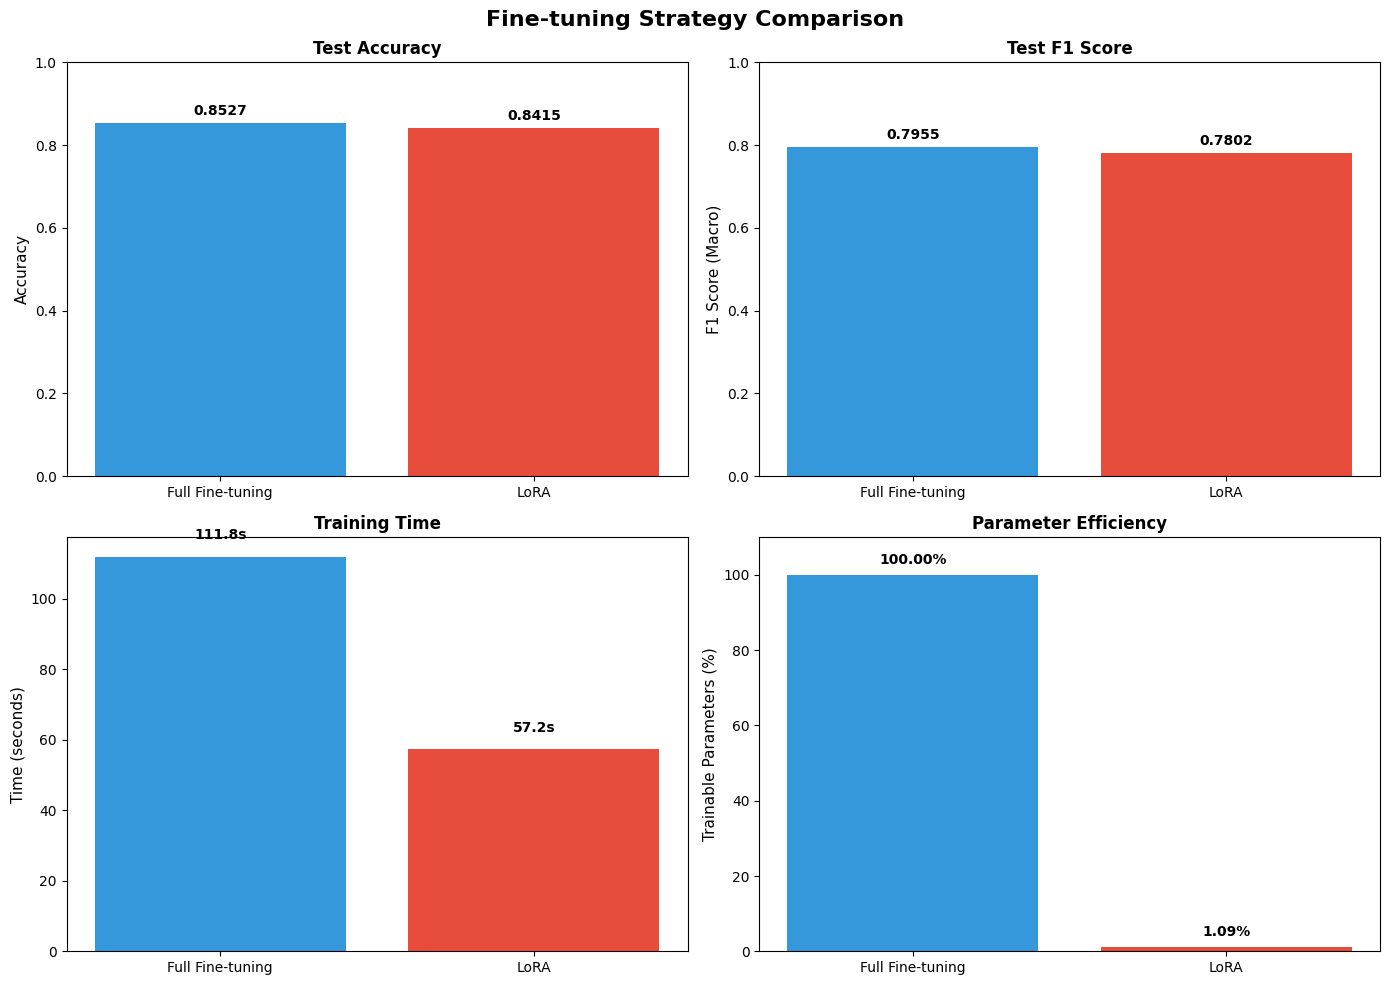

ASSIGNMENT COMPLETE!

Key Findings:
1. Full fine-tuning updates all model parameters
2. LoRA only updates ~0.5-1% of parameters while maintaining performance
3. LoRA is more memory-efficient and often trains faster
4. Both strategies achieve competitive performance on this task


In [5]:
# 5. MAIN EXECUTION

def main():
    print("Ng Rui Bin, Damien IA3")
    print("Comparing Full Fine-tuning vs LoRA on Financial Sentiment Analysis")

    # initialise
    model_name = "distilbert-base-uncased"

    # step 1: prepare data
    data_prep = DatasetPreparation(model_name)
    dataset = data_prep.load_and_split_data()
    tokenized_dataset = data_prep.tokenize_data()

    # step 2: initialise model setup
    model_setup = ModelSetup(model_name, num_labels=3)

    # step 3: initialise trainer
    trainer = ModelTrainer(tokenized_dataset)

    # step 4: initialise results comparison
    comparison = ResultsComparison()

    # strategy 1: Full Fine-tuning
    print("EXECUTING STRATEGY 1: FULL FINE-TUNING")
    full_model = model_setup.create_full_finetuning_model()
    full_results = trainer.train_model(full_model, "Full Fine-tuning", epochs=3)
    comparison.add_results("Full Fine-tuning", full_results)

    # strategy 2: LoRA
    print("EXECUTING STRATEGY 2: LoRA")
    lora_model = model_setup.create_lora_model(r=8, lora_alpha=16)
    lora_results = trainer.train_model(lora_model, "LoRA", epochs=3)
    comparison.add_results("LoRA", lora_results)

    # step 5: compare and output diagrams
    comparison.compare_strategies()
    comparison.plot_comparison()

    print("ASSIGNMENT COMPLETE!")
    print("\nKey Findings:")
    print("1. Full fine-tuning updates all model parameters")
    print("2. LoRA only updates ~0.5-1% of parameters while maintaining performance")
    print("3. LoRA is more memory-efficient and often trains faster")
    print("4. Both strategies achieve competitive performance on this task")

    return comparison

# Run the assignment
if __name__ == "__main__":
    results = main()